In [6]:
%%capture --no-display

# Librairies pour compilation_donnees
! pip install pandas py7zr geopandas scipy matplotlib

In [ ]:
%%capture --no-display

# Librairies et setup pour effectuer le scrapping
# ! pip install pytest-playwright playwright_stealth asyncio
# ! sudo playwright install-deps
# ! playwright install

# 1 - Traitement et importation des données

## Données tabulaires

Toutes les fonctions d'extraction de données brutes se trouvent dans le script `scripts/compilation_donnees.py`. Les fonctions `importer_tout()` et `importer_locale(date)` permettent d'importer toutes les sources.

In [1]:
from scripts.compilation_donnees import *

## Importer les données depuis les APIs (plus lent)
# from scripts.importation_donnees_tabuaires import *
# df_SAE, df_SAE_2011, df_dep, df_finess, df_drees, df_pauv = importer_tout() 

## Importer une sauvegarde locale récente des données
from scripts.compilation_donnees import *
df_SAE, df_SAE_2011, df_dep, df_finess, df_drees, df_pauv, df_doctolib = importer_locale("2025-12-16-17-35", "2025-11-20-14-56")

Travail sur les données DREES pour réaliser des évolutions dans le temps au niveau national : juste présenter les données comme y'a déjà publier sur la DREES 

<Axes: title={'center': "Évolution nombre total d'IVG en France de 2016 à 2024"}, xlabel='annee'>

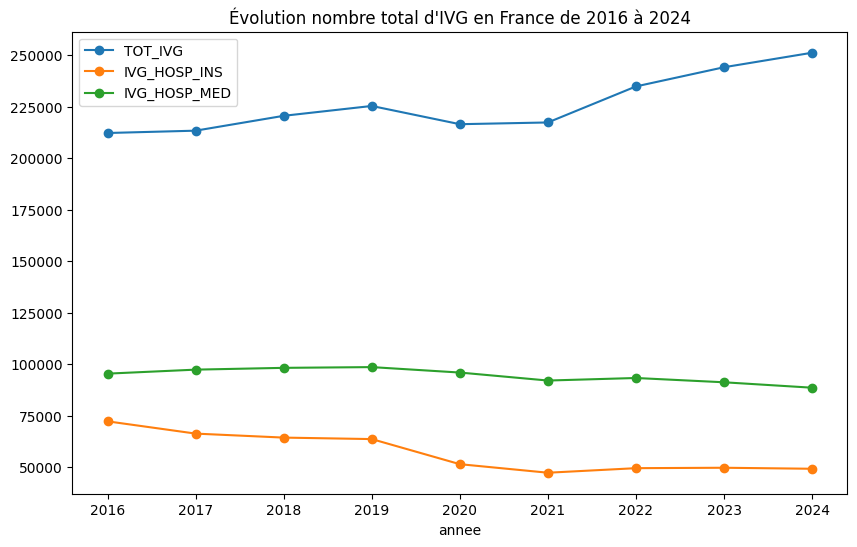

In [8]:
df_drees_filtre = df_drees[df_drees["zone_geo"] == "France entière"]
df_drees_filtre.plot(x="annee", y=["TOT_IVG", "IVG_HOSP_INS", "IVG_HOSP_MED"], kind="line", marker='o', figsize=(10,6), title="Évolution nombre total d'IVG en France de 2016 à 2024")

La hausse du nombre d’IVG depuis 2022 se poursuit, après la nette baisse en 2020 et 2021 en lien avec la pandémie de Covid-19.
Le nombre d’IVG a tendance a augmenté depuis 2017. Cette hausse est interrompu en 2020 et 2021, où le nombre d’IVG connait une chute en lien avec la pandémie de Covid-19. Depuis 2022, ce chiffre augmente de nouveau, et plus rapidement que précédemment. 
Le nombre d’IVG tardive suit une évolution similaire. Néanmoins, la hausse est plus faible que celle du nombre d’IVG totale entre 2023 et 2024, ce qui peut indiquer un changement des pratiques, qui suit le changement législatif de 2022. En effet, depuis 2022, il est légal de recourir à une IVG après 14 semaines de grossesse, deux semaines de plus qu’auparavant. 

In [9]:
valeur_min = df_dep_ivg["femmes"].min()

print(valeur_min) # 27982 < 100 000 : donc on conserve pr avoir un chiffre interprétable mais pas réaliste pr certains départements

19,Centre de sante sexuelle,CeGIDD
département,,
AIN,1,2
AISNE,5,3
ALLIER,3,3
ALPES DE HAUTE PROVENCE,0,0
ALPES MARITIMES,8,1


In [10]:
df_dep.head(5)

code_dep              département    femmes
0       01                      Ain  289335.0
1       02                    Aisne  207602.0
2       03                   Allier  117763.0
3       04  Alpes-de-Haute-Provence   59730.0
4       05             Hautes-Alpes   51076.0

Pour la SAE

In [11]:
df_SAE_2011.rename(columns={'DEP': 'code_dep'}, inplace=True)
df_SAE_2011.head()

code_dep département  femmes  pris  conv  centre_de_sante_sexuelle  cegidd  \
0       01         Ain  289335   5.0   1.0                       1.0     2.0   
1       01         Ain  289335   5.0   1.0                       1.0     2.0   
2       01         Ain  289335   5.0   1.0                       1.0     2.0   
3       01         Ain  289335   5.0   1.0                       1.0     2.0   
4       01         Ain  289335   5.0   1.0                       1.0     2.0   

  delai_moy_pec_ivg                            CATEGORIE code_dep  
0        sans objet  Etablissement de soins chirurgicaux       01  
1        sans objet              Centre hospitalier (CH)       01  
2        sans objet              Centre hospitalier (CH)       01  
3                10              Centre hospitalier (CH)       01  
4                 6              Centre hospitalier (CH)       01

In [12]:
df_SAE.rename(columns={'fi': 'FI', 'dep': 'code_dep'}, inplace=True)

# nb centre qui prend en charge les IVG par département 
df_prise_en_charge_dep = (
    df_SAE
    .groupby('code_dep')[['PRIS', 'CONV']]
    .sum()
    .reset_index()
)
df_dep_ivg = pd.merge(df_prise_en_charge_dep, df_dep, on=['code_dep'], how='outer') # on merge les deux bases 

df_dep_ivg['département'] = (
    df_dep_ivg['département']
        .str.replace('-', ' ', regex=False)
        .str.upper()
) # modifier la typo de la colonne Département 

df_dep_ivg = pd.merge(df_dep_ivg, df_nbcentre, on=['département'], how='outer')

In [13]:
df_ivg_sans_tard = (
    df_SAE
    .loc[
        (df_SAE['IVG1214'].fillna(0) == 0) &
        (df_SAE['IVG1516'].fillna(0) == 0)
    ]
    .groupby('code_dep')
    .size()
    .reset_index(name='nb_hopitaux_sans_ivg_tard')
)
df_dep_ivg = pd.merge(df_dep_ivg, df_ivg_sans_tard, on=['code_dep'], how='outer')
df_dep_ivg['nb_hopitaux_sans_ivg_tard'] = df_dep_ivg['nb_hopitaux_sans_ivg_tard'].fillna(0)

In [14]:
df_dep_ivg["centres_total"] = df_dep_ivg["Centre de sante sexuelle"] + df_dep_ivg["CeGIDD"]

def par100k(x):
    return (x/df_dep_ivg["femmes"])*100000

df_dep_ivg["PRIS_pour100kfe"] = par100k(df_dep_ivg["PRIS"])
df_dep_ivg["centres_pour100kfe"] = par100k(df_dep_ivg["Centre de sante sexuelle"])
df_dep_ivg["cegidd_pour100kfe"] = par100k(df_dep_ivg["CeGIDD"])
df_dep_ivg["centres_total_pour100kfe"] = par100k(df_dep_ivg["centres_total"])
df_dep_ivg["hop_sansIVGtard_pour100kfe"] = par100k(df_dep_ivg["nb_hopitaux_sans_ivg_tard"])
valeur_min = df_dep_ivg["femmes"].min()

print(valeur_min) # 27982 < 100 000 : donc on conserve pr avoir un chiffre interprétable mais pas réaliste pr certains départements

27982.0


Pour le taux de pauvreté,

In [15]:
df = jointure(df_SAE, df_SAE_2011, df_dep, df_finess, df_drees, df_pauv, df_doctolib)
df.head(5)

,code_dep,Département,taux_pauvrete
0,01,Ain,10.8
1,02,Aisne,18.8
2,03,Allier,16.2
3,04,Alpes-de-Haute-Provence,17.1
4,05,Hautes-Alpes,14.7


## Web Scrapping - Doctolib

Pour avoir un **indice de la disponibilité des IVGs en France**, nous allons utiliser des données issues du site de prise de rendez-vous médicales le plus utilisé en France, **Doctolib**. Par département et spécialisation IVG, les données extraites sont le nombre de localisations différentes proposant un RDV IVG dans un délai de 14, 30 et 90 jours. Ces données sont accessibles à tous gratuitement en utilisant leur moteur de recherche et des filtres (par [ex](https://www.doctolib.fr/ivg-medicamenteuse/paris?availabilitiesBefore=90&regulationSector%5B%5D=CONTRACTED_1&regulationSector%5B%5D=CONTRACTED_1_WITH_EXTRA&regulationSector%5B%5D=CONTRACTED_1_WITH_OPTAM&regulationSector%5B%5D=CONTRACTED_1_WITH_OPTAM_CO&regulationSector%5B%5D=CONTRACTED_2&regulationSector%5B%5D=CONTRACTED_2_WITH_OPTAM&regulationSector%5B%5D=CONTRACTED_2_WITH_OPTAM_CO&regulationSector%5B%5D=CONTRACTED&regulationSector%5B%5D=CONTRACTED_WITH_EXTRA&regulationSector%5B%5D=ORGANIZATION_CONTRACTED)).

Pour la mise en oeuvre, le script est `scrapper_doctolib.py` qui crée un .csv à l'aboutissement. Le script s'appuie sur la librairie `Playwright` permet de faire du web scrapping sur des sites dynamiques (comme Doctolib qui utilise react et javascript) en utilisant des navigateurs "headless" dans l'arrière plan. Avant de finir sur cette librairie, d'autres options ont été tentées : `BeautifulSoup` (pour adapté au parsing des sites statiques) et `Selenium` (une autre librairie de "headless browsers"). Cependant, `Playwright` a était le plus agile pour la gestion du chargement de la page. De plus, `asyncio` est utilisé pour faire du parallélisme et réduire le temps de scrapping.

> Point législatif
> 
> [Source (CNIL) : ](https://www.cnil.fr/fr/focus-interet-legitime-collecte-par-moissonnage)

Exemple des données obtenues (format dataframe pandas) suite au scraping (environ une demi-heure) :

In [16]:
df_doctolib = pd.read_csv("./donnees/doctolib_2025-11-20-14-56.csv")
# df_doctolib['code_dep'] = df_doctolib['departement'].map(dictionnaire_departements).astype(str).str.zfill(2)
df_doctolib.head()

,departement,specialite,trimestre,mois,deuxSemaines,code_dep
0,ain,ivg-chirurgicale,0,0,0,01
1,ain,ivg-medicale-et-chirurgicale,1,1,1,01
2,ain,ivg-medicamenteuse,87,77,69,01
3,aisne,ivg-chirurgicale,0,0,0,02
4,aisne,ivg-medicale-et-chirurgicale,0,0,0,02


In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [21]:
url = "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb" 
geo = gpd.read_file(url)

In [23]:
geo['code_dep'] = geo['code'].astype(str).str.zfill(2)
gdf = pd.merge(df_doctolib, geo, on='code_dep', how='left')

In [ ]:
gdf.head()

In [24]:
aggregated = gdf.groupby(['code', 'nom', 'geometry'], as_index=False).agg({
    'trimestre': 'sum',
    'mois': 'sum',
    'deuxSemaines': 'sum'
})
aggregated.head()

,code,nom,geometry,trimestre,mois,deuxSemaines
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...",88,78,70
1,02,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...",6,5,5
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.7908, 3...",9,9,7
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...",10,9,6
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...",11,11,9


In [ ]:
# import geopandas as gpd
# import folium
# import mapclassify
# import matplotlib

# gdf_aggregated = gpd.GeoDataFrame(aggregated)

# gdf_aggregated.explore(
#     column="trimestre",
#     scheme="quantiles", 
#     legend=True,
#     tooltip=["nom", "trimestre", "mois", "deuxSemaines"],
#     cmap="Reds",
#     tiles="CartoDB positron",
#     k=10,                 
#     legend_kwds=dict(colorbar=True)
# )


ModuleNotFoundError: No module named 'folium'

Cette carte présente les taux de disponibilité d’IVG dans un délai de moins de 3 mois via doctolib dans un département. Les disparités territoriales sont importantes. Certains départements comme l’Ile-de-France et …. ont une plus grande offre de rendez-vous médicaux pour réaliser une IVG, quelque soit le professionnel de santé. D’autres, comme …, ont seulement … offre pour 1000 femmes. Ces constats révèlent des offres différenciées selon les départements, et donc des inégalités territoriales pour recourir à une IVG. 

In [35]:
gdf_aggregated = gpd.GeoDataFrame(aggregated)
gdf_aggregated = pd.merge(aggregated, df_dep, left_on='code', right_on='code_dep', how='left')
gdf_aggregated.drop(['code', 'nom'], axis=1)

,geometry,trimestre,mois,deuxSemaines,code_dep,département,femmes
0,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...",88,78,70,01,Ain,289335.0
1,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...",6,5,5,02,Aisne,207602.0
2,"POLYGON ((3.03207 46.79491, 3.03424 46.7908, 3...",9,9,7,03,Allier,117763.0
3,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...",10,9,6,04,Alpes-de-Haute-Provence,59730.0
4,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...",11,11,9,05,Hautes-Alpes,51076.0
...,...,...,...,...,...,...,...
91,"POLYGON ((2.22656 48.7761, 2.22866 48.77451, 2...",33,31,23,91,Essonne,614879.0
92,"POLYGON ((2.29097 48.95097, 2.29162 48.95077, ...",128,118,109,92,Hauts-de-Seine,809206.0
93,"POLYGON ((2.55306 49.00982, 2.55814 49.01201, ...",204,192,162,93,Seine-Saint-Denis,846920.0
94,"POLYGON ((2.3319 48.81701, 2.33371 48.81677, 2...",118,114,98,94,Val-de-Marne,687162.0


In [36]:
gdf_aggregated['trimestre_norm'] = gdf_aggregated['trimestre']/(gdf_aggregated['femmes'])*100000
gdf_aggregated['deuxSemaines_norm'] = gdf_aggregated['deuxSemaines']/(gdf_aggregated['femmes'])*100000
gdf_aggregated['mois_norm'] = gdf_aggregated['mois']/(gdf_aggregated['femmes'])*100000

In [19]:
# gdf_aggregated = gpd.GeoDataFrame(gdf_aggregated)

# gdf_aggregated.explore(
#     column="trimestre_norm",
#     scheme="quantiles", 
#     legend=True,
#     tooltip=["nom", "trimestre_norm", "mois_norm", "deuxSemaines_norm"],
#     cmap="Reds",
#     tiles="CartoDB positron",
#     k=10,                 
#     legend_kwds=dict(colorbar=True)
# )


In [38]:
main = pd.merge(gdf_aggregated, df_dep_ivg, on='code_dep', how='outer')

In [39]:
main.head()

,code,nom,geometry,trimestre,mois,deuxSemaines,code_dep,département_x,femmes_x,trimestre_norm,...,femmes_y,Centre de sante sexuelle,CeGIDD,nb_hopitaux_sans_ivg_tard,centres_total,PRIS_pour100kfe,centres_pour100kfe,cegidd_pour100kfe,centres_total_pour100kfe,hop_sansIVGtard_pour100kfe
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...",88,78,70,01,Ain,289335.0,30.414571,...,289335.0,1.0,2.0,1.0,3.0,1.382481,0.345620,0.691240,1.036860,0.345620
1,02,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...",6,5,5,02,Aisne,207602.0,2.890146,...,207602.0,5.0,3.0,0.0,8.0,2.408455,2.408455,1.445073,3.853527,0.000000
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.7908, 3...",9,9,7,03,Allier,117763.0,7.642468,...,117763.0,3.0,3.0,1.0,6.0,3.396653,2.547489,2.547489,5.094979,0.849163
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...",10,9,6,04,Alpes-de-Haute-Provence,59730.0,16.742006,...,59730.0,0.0,0.0,0.0,0.0,3.348401,0.000000,0.000000,0.000000,0.000000
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...",11,11,9,05,Hautes-Alpes,51076.0,21.536534,...,51076.0,2.0,0.0,1.0,2.0,5.873600,3.915733,0.000000,3.915733,1.957867


# Traitements des données : CAH et régression

On réalise tout d'abord une régression linéaire simple, afin d'analyser la corrélation entre le taux de pauvreté d'un département et 

In [22]:
X = main[["taux_pauvrete"]]
X = sm.add_constant(X)
y = main["trimestre_norm"]

model = LinearRegression()
model = sm.OLS(y, X).fit()

print(model.summary())

KeyError: "None of [Index(['taux_pauvrete'], dtype='object')] are in the [columns]"

In [ ]:
X = main[["taux_pauvrete", "PRIS_pour100kfe", "hop_sansIVGtard_pour100kfe", "centres_pour100kfe"]]
X = sm.add_constant(X)
y = main["trimestre_norm"]

model = LinearRegression()
model = sm.OLS(y, X).fit()

print(model.summary())

## Classification ascendante hiérarchique  

Afin de réaliser une typplogie des départements selon le profil des pratiques d'IVG, nous réaliser une Classification ascendante hiérarchique (CAH). 

Tout d'abord, nous réalisons un dendrogramme afin de déterminer le nombre de classes dans la CAH. 

In [ ]:
X = main[[
    "VAR1", "VAR2", "VAR3", ..., "VAR15"
]] # mettre les variables qu'on veut pour la CAH 

#scaler = StandardScaler() si on veut normaliser 
# X_scaled = scaler.fit_transform(X)
# Méthode de liaison (Ward est la plus utilisée)
Z = linkage(X, method="ward")

plt.figure(figsize=(10, 6))
dendrogram(
    Z,
    labels=df_drees_filtre["code_dep"].values,
    leaf_rotation=45
)
plt.title("Dendrogramme - CAH")
plt.xlabel("Département")
plt.ylabel("Distance")
plt.show()

Nous réalisons ensuite la CAH avec ... de classes. Ici le code run pour 3. 

In [ ]:
clusters = fcluster(Z, t=3, criterion='maxclust')
score = silhouette_score(X_scaled, clusters)
print("Silhouette score :", score)

On étudie les profils moyens par classes. Faire de la visu avec des cartes. 

In [ ]:
main.groupby("cluster")[[
    "VAR1", "VAR2", ..., "VAR15"
]].mean()
